# Previous imports

In [1]:
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from qiskit_machine_learning.algorithms import QSVC

# Dataset creation

In [2]:
algorithm_globals.random_seed = 1529

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=35,
    test_size=10,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

## Plotting the dataset

In [3]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()
    
def plot_dataset_bg(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset: boundary estimation")

    plt.show()

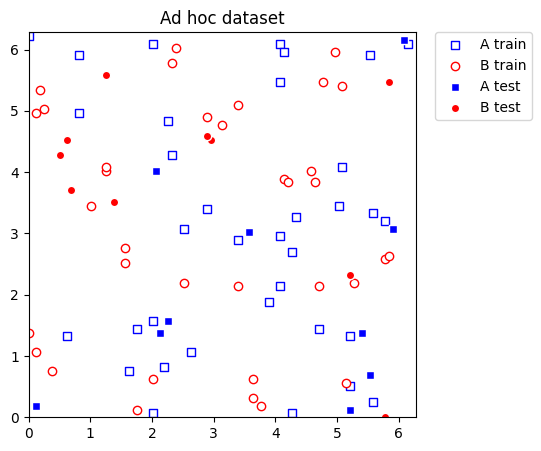

In [4]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

# Defining the quantum kernel

In [5]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

# Tests

## Classifying with Kernel as a function

In [6]:
adhoc_svc_callable = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc_callable.fit(train_features, train_labels)

svc_callable_predictions = adhoc_svc_callable.predict(test_features)

adhoc_score_callable_function = adhoc_svc_callable.score(test_features, test_labels)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


## Classifying with precomputed matrix

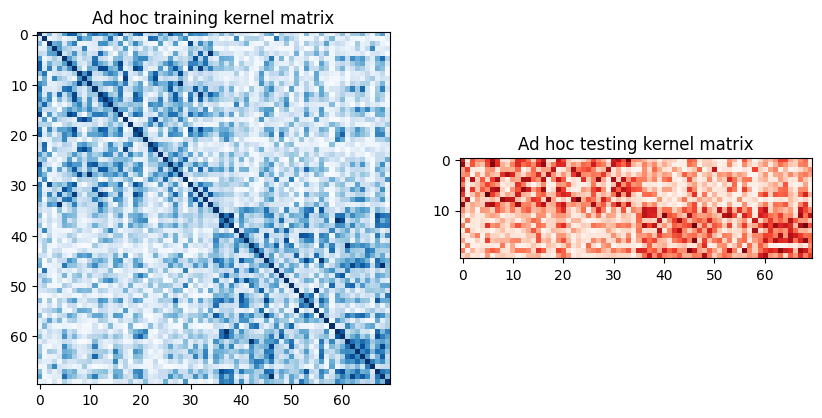

In [7]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [8]:
adhoc_svc_precomputed = SVC(kernel="precomputed")
adhoc_svc_precomputed.fit(adhoc_matrix_train, train_labels)

svc_precomputed_predictions = adhoc_svc_precomputed.predict(adhoc_matrix_test)

adhoc_score_precomputed_kernel = adhoc_svc_precomputed.score(adhoc_matrix_test, test_labels)
print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


## Classifying with QSVC

In [9]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(train_features, train_labels)

qsvc_predictions = qsvc.predict(test_features)

qsvc_score = qsvc.score(test_features, test_labels)
print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


# Model evaluation

## Accuracy score

In [10]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


## Model predictions

In [11]:
# verify predictions
def check_predictions(predictions, test_labels):
    correct = np.where(predictions == test_labels)[0]
    incorrect = np.where(predictions != test_labels)[0]
    print("Correctly classified instances: \n", test_features[correct])
    print("Incorrectly classified instances: \n", test_features[incorrect])

In [12]:
# Instances that were classified correctly and incorrectly
correct_indices_callable = np.where(svc_callable_predictions == test_labels)[0]
incorrect_indices_callable = np.where(svc_callable_predictions != test_labels)[0]
correct_indices_precomputed = np.where(svc_precomputed_predictions == test_labels)[0]
incorrect_indices_precomputed = np.where(svc_precomputed_predictions != test_labels)[0]
correct_indices_qsvc = np.where(qsvc_predictions == test_labels)[0]
incorrect_indices_qsvc = np.where(qsvc_predictions != test_labels)[0]

print("\nSVC (kernel as a callable function):")
print("Indexes of correctly classified instances:", correct_indices_callable)
print("Indexes of incorrectly classified instances:", incorrect_indices_callable)
check_predictions(svc_callable_predictions, test_labels)

print("\nSVC (precomputed kernel matrix):")
print("Indexes of correctly classified instances:", correct_indices_precomputed)
print("Indexes of incorrectly classified instances:", incorrect_indices_precomputed)
check_predictions(svc_precomputed_predictions, test_labels)

print("\nQSVC:")
print("Indexes of the correctly classified instances:", correct_indices_qsvc)
print("Indexes of the incorrectly classified instances:", incorrect_indices_qsvc)
check_predictions(qsvc_predictions, test_labels)


SVC (kernel as a callable function):
Indexes of correctly classified instances: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Indexes of incorrectly classified instances: []
Correctly classified instances: 
 [[3.58141563 3.01592895]
 [2.136283   1.38230077]
 [5.40353936 1.38230077]
 [5.52920307 0.69115038]
 [5.2150438  0.12566371]
 [0.12566371 0.18849556]
 [2.26194671 1.57079633]
 [6.09468975 6.1575216 ]
 [2.07345115 4.0212386 ]
 [5.90619419 3.0787608 ]
 [1.38230077 3.51858377]
 [0.69115038 3.70707933]
 [2.95309709 4.52389342]
 [5.84336234 5.46637122]
 [2.89026524 4.58672527]
 [0.50265482 4.27256601]
 [1.25663706 5.59203492]
 [5.78053048 0.        ]
 [5.2150438  2.32477856]
 [0.62831853 4.52389342]]
Incorrectly classified instances: 
 []

SVC (precomputed kernel matrix):
Indexes of correctly classified instances: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Indexes of incorrectly classified instances: []
Correctly classified instances: 
 [[3.58141563 3

In [13]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label, size=20):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
        s=size,
    )

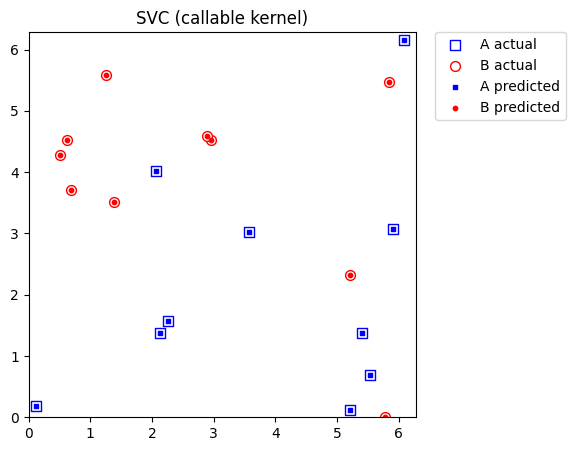

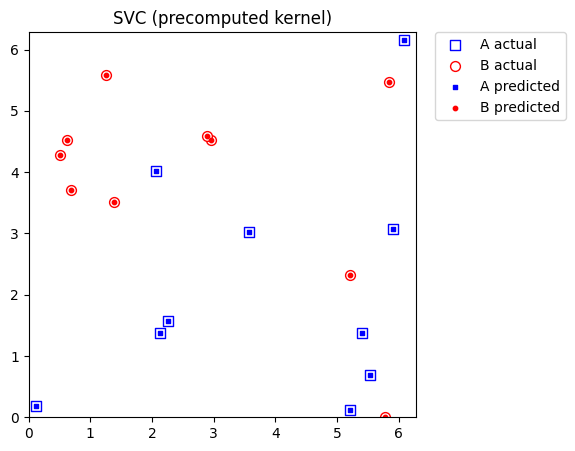

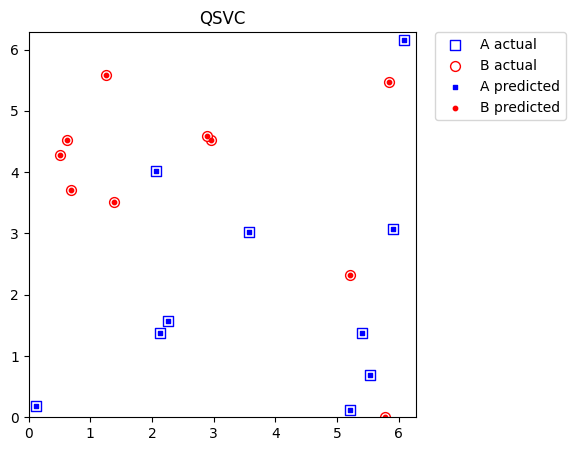

In [14]:
def plot_predictions(features, labels, predictions, title):
    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)

    # Plot the actual labels
    plot_features(plt, features, labels, 0, "s", "w", "b", "A actual",size = 50)
    plot_features(plt, features, labels, 1, "o", "w", "r", "B actual",size = 50)

    # Plot the predicted labels
    plot_features(plt, features, predictions, 0, "s", "b", None, "A predicted", size = 10)
    plot_features(plt, features, predictions, 1, "o", "r", None, "B predicted", size = 10)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title(title)
    plt.show()


# Now you can call the above function to plot the predictions from each model
plot_predictions(test_features, test_labels, svc_callable_predictions, "SVC (callable kernel)")
plot_predictions(test_features, test_labels, svc_precomputed_predictions, "SVC (precomputed kernel)")
plot_predictions(test_features, test_labels, qsvc_predictions, "QSVC")


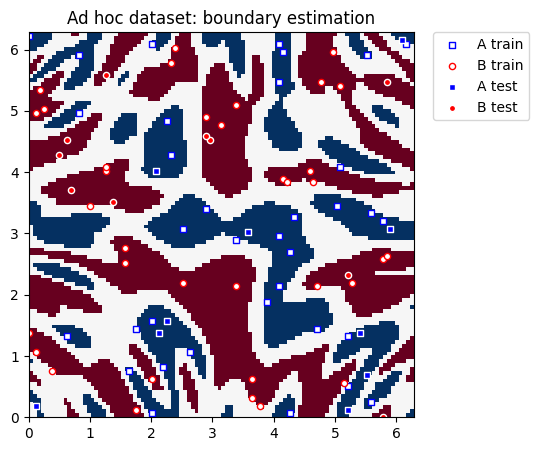

In [15]:
plot_dataset_bg(train_features, train_labels, test_features, test_labels, adhoc_total)